In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from keras.optimizers import Adam
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import ast
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping


In [ ]:
dataset = pd.read_csv('merged_dataset.csv')

In [ ]:
def is_float(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [ ]:
dataset['landmarks'] = dataset['landmarks'].apply(lambda arr: np.array([float(n) for n in arr.split() if is_float(n)]))

In [ ]:
dataset['Label'].value_counts()

good    8593
bad     7051
Name: Label, dtype: int64

In [ ]:
# Group the data by 'video' and 'group'
grouped_data = dataset.groupby(['video', 'group'])

# Define the sequence length
sequence_length = 10

# Create lists to store the sequences and labels
sequences = []
labels = []

# Iterate over each group
for group, data in grouped_data:
    landmarks = data['landmarks'].tolist()
    group_labels = data['Label'].tolist()

    # Create sequences of landmarks
    for i in range(len(landmarks) - sequence_length + 1):
        sequence = landmarks[i:i+sequence_length]
        sequences.append(sequence)
        labels.append(group_labels[i+sequence_length-1])

In [ ]:
sequences = np.array(sequences)

scaler = MinMaxScaler()
normalized_sequences = np.zeros_like(sequences)

for i in range(sequences.shape[0]):
    for j in range(sequences.shape[1]):
        # Flatten the landmarks for each set within the sequence
        landmarks_flattened = np.reshape(sequences[i, j], (-1, 1))
        # Normalize the landmarks
        landmarks_normalized = scaler.fit_transform(landmarks_flattened)
        # Reshape the normalized landmarks back to the original shape
        normalized_landmarks = np.reshape(landmarks_normalized, sequences[i, j].shape)
        # Update the normalized landmarks in the sequences array
        normalized_sequences[i, j] = normalized_landmarks

In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(normalized_sequences, labels_encoded, test_size=0.2, shuffle=True)

In [ ]:
print(train_X.shape)
print(train_y.shape)

(1188, 10, 50)
(1188,)


In [ ]:
train_X_tensor = torch.Tensor(train_X)
train_y_tensor = torch.Tensor(train_y)

In [ ]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
num_features = normalized_sequences.shape[2]

# First Model Working

In [ ]:

# Define the LSTM model
model_ex0 = Sequential()
model_ex0.add(LSTM(units=32, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex0.add(Dropout(0.7))
model_ex0.add(LSTM(units=64))
model_ex0.add(Dropout(0.5))
model_ex0.add(Dense(units=1, activation='sigmoid'))

custom_learning_rate = 0.0001
optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model
model_ex0.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model_ex0.summary()

# Train the model
batch_size = 32
epochs = 200
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex0 = model_ex0.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            10624     
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 35,521
Trainable params: 35,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
30/30 [==============================] -

In [ ]:
# Evaluate the model
test_predictions = model_ex0.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex0.evaluate(test_X, test_y)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 5ms/step - loss: 0.4104 - accuracy: 0.8456
Test Loss: 0.4104210138320923
Test Accuracy: 0.8456375598907471
Test F1-Score: 0.8359133126934984
Test Recall: 0.84375


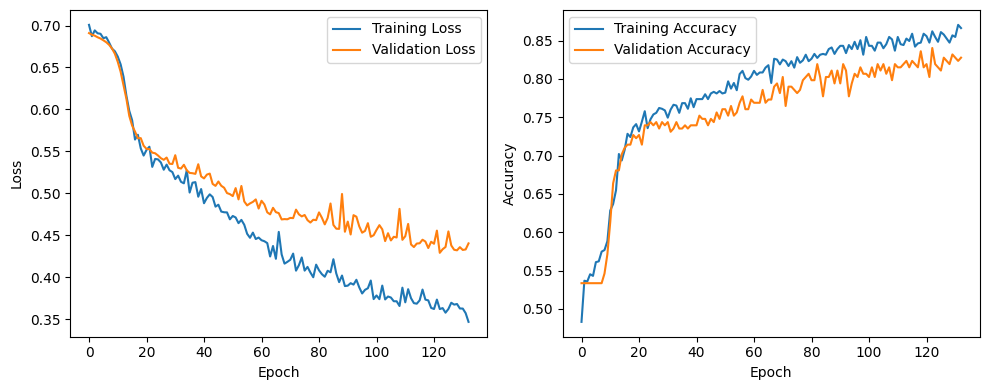

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex0.history['loss'], label='Training Loss')
plt.plot(history_ex0.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex0.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex0.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

10/10 [==============================] - 0s 6ms/step


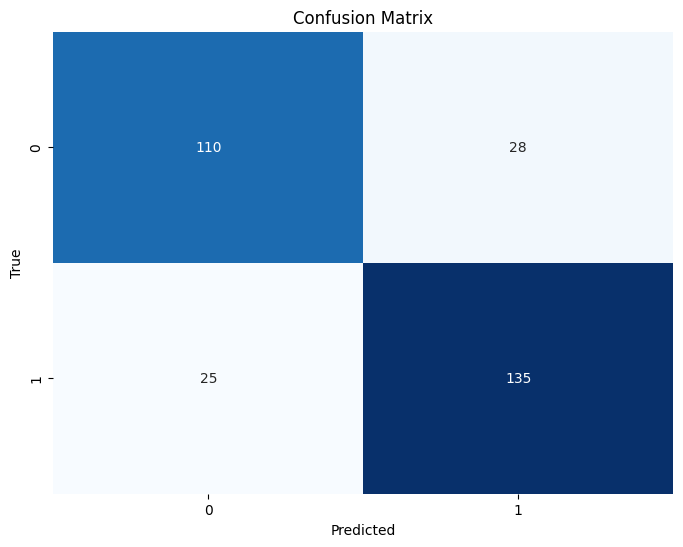

In [ ]:
# Predict probabilities on test data
predictions = model_ex0.predict(test_X)

# Convert probabilities to binary classes using a threshold (e.g., 0.5)
predicted_classes = (predictions > 0.7).astype(int)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_y, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_ex0.save('lstm_model_ex0.h5')

# Experiments

## Experiment 1
Test Loss: 0.3311097323894501

Test Accuracy: 0.8691275119781494

In [ ]:
model_ex1 = Sequential()
model_ex1.add(LSTM(units=128, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex1.add(Dropout(0.3))
model_ex1.add(LSTM(units=64))
model_ex1.add(Dropout(0.5))
model_ex1.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_ex1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
epochs = 100
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex1 = model_ex1.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/100
30/30 [==============================] - 12s 175ms/step - loss: 0.6823 - accuracy: 0.5421 - val_loss: 0.6466 - val_accuracy: 0.6218
Epoch 2/100
30/30 [==============================] - 2s 82ms/step - loss: 0.6111 - accuracy: 0.6926 - val_loss: 0.6143 - val_accuracy: 0.6849
Epoch 3/100
30/30 [==============================] - 3s 87ms/step - loss: 0.5567 - accuracy: 0.7389 - val_loss: 0.6673 - val_accuracy: 0.6471
Epoch 4/100
30/30 [==============================] - 3s 102ms/step - loss: 0.5535 - accuracy: 0.7284 - val_loss: 0.5442 - val_accuracy: 0.7311
Epoch 5/100
30/30 [==============================] - 3s 87ms/step - loss: 0.5302 - accuracy: 0.7358 - val_loss: 0.5354 - val_accuracy: 0.7353
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4987 - accuracy: 0.7611 - val_loss: 0.5295 - val_accuracy: 0.7521
Epoch 7/100
30/30 [==============================] - 2s 65ms/step - loss: 0.4902 - accuracy: 0.7726 - val_loss: 0.5128 - val_accuracy: 0.7521
Epo

In [ ]:
test_predictions = model_ex1.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex1.evaluate(test_X, test_y)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

test_loss, test_accuracy= model_ex1.evaluate(test_X, test_y)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 18ms/step - loss: 0.3826 - accuracy: 0.8490
Test Loss: 0.38260623812675476
Test Accuracy: 0.8489933013916016
Test F1-Score: 0.8862275449101797
Test Recall: 0.925
10/10 [==============================] - 0s 18ms/step - loss: 0.3826 - accuracy: 0.8490
Test Loss: 0.38260623812675476
Test Accuracy: 0.8489933013916016
Test F1-Score: 0.8862275449101797
Test Recall: 0.925


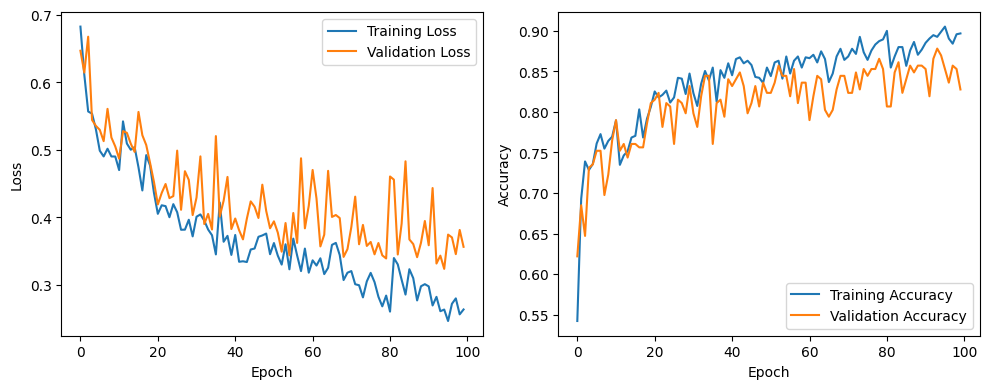

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex1.history['loss'], label='Training Loss')
plt.plot(history_ex1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex1.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

10/10 [==============================] - 0s 9ms/step


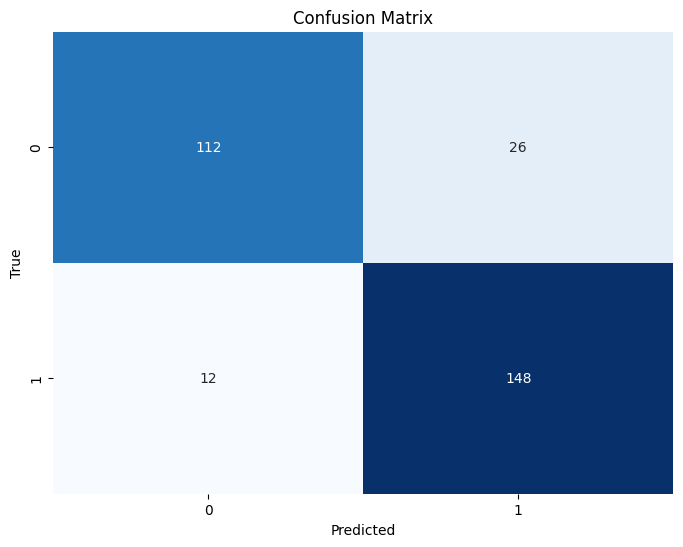

In [ ]:
# Predict probabilities on test data
predictions = model_ex1.predict(test_X)

# Convert probabilities to binary classes using a threshold (e.g., 0.5)
predicted_classes = (predictions > 0.7).astype(int)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_y, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_ex1.save('lstm_model_ex1.h5')

### Experiment 1.1 (6)

Test Loss: 0.40347662568092346

Test Accuracy: 0.8892617225646973



In [ ]:
model_ex1v2 = Sequential()
model_ex1v2.add(LSTM(units=128, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex1v2.add(Dropout(0.5))
model_ex1v2.add(LSTM(units=64))
model_ex1v2.add(Dropout(0.7))
model_ex1v2.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_ex1v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
epochs = 200
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex6 = model_ex1v2.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/200
30/30 [==============================] - 13s 103ms/step - loss: 0.6953 - accuracy: 0.5516 - val_loss: 0.6576 - val_accuracy: 0.6261
Epoch 2/200
30/30 [==============================] - 2s 52ms/step - loss: 0.6330 - accuracy: 0.6537 - val_loss: 0.6707 - val_accuracy: 0.5882
Epoch 3/200
30/30 [==============================] - 1s 48ms/step - loss: 0.5649 - accuracy: 0.7274 - val_loss: 0.5511 - val_accuracy: 0.7395
Epoch 4/200
30/30 [==============================] - 2s 70ms/step - loss: 0.5780 - accuracy: 0.7042 - val_loss: 0.5561 - val_accuracy: 0.7185
Epoch 5/200
30/30 [==============================] - 2s 53ms/step - loss: 0.5705 - accuracy: 0.7042 - val_loss: 0.5551 - val_accuracy: 0.7185
Epoch 6/200
30/30 [==============================] - 1s 50ms/step - loss: 0.5637 - accuracy: 0.7337 - val_loss: 0.5610 - val_accuracy: 0.7059
Epoch 7/200
30/30 [==============================] - 2s 55ms/step - loss: 0.5211 - accuracy: 0.7526 - val_loss: 0.5236 - val_accuracy: 0.7353
Epoc

In [ ]:
test_predictions = model_ex1v2.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex1v2.evaluate(test_X, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 15ms/step - loss: 0.5672 - accuracy: 0.8356
Test Loss: 0.567160427570343
Test Accuracy: 0.8355704545974731
Test F1-Score: 0.85
Test Recall: 0.85


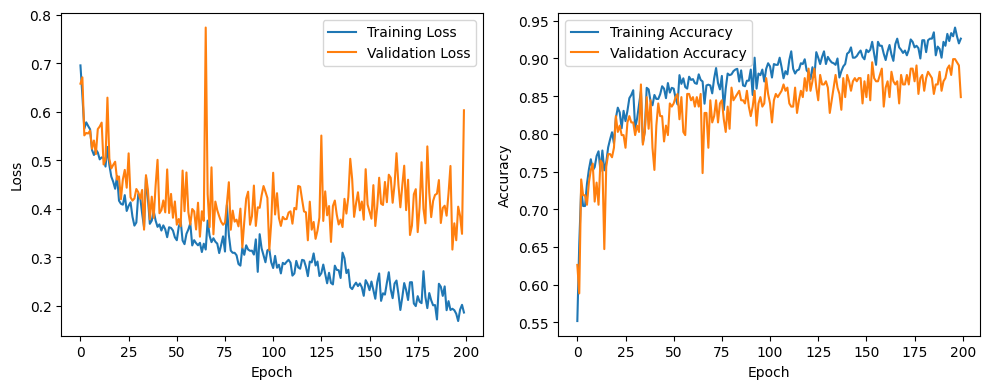

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex6.history['loss'], label='Training Loss')
plt.plot(history_ex6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex6.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex6.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_ex1v2.save('lstm_model_ex1v2.h5')

## Experiment 2

Test Loss: 0.3368649184703827

Test Accuracy: 0.8758389353752136

In [ ]:
model_ex2 = Sequential()
model_ex2.add(LSTM(units=64, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex2.add(Dropout(0.7))
model_ex2.add(LSTM(units=64, return_sequences=True))
model_ex2.add(LSTM(units=32))
model_ex2.add(Dropout(0.7))
model_ex2.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_ex2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex2 = model_ex2.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/100
30/30 [==============================] - 10s 116ms/step - loss: 0.6920 - accuracy: 0.5558 - val_loss: 0.6839 - val_accuracy: 0.5294
Epoch 2/100
30/30 [==============================] - 1s 27ms/step - loss: 0.6669 - accuracy: 0.5874 - val_loss: 0.6495 - val_accuracy: 0.6092
Epoch 3/100
30/30 [==============================] - 1s 25ms/step - loss: 0.6214 - accuracy: 0.6695 - val_loss: 0.6308 - val_accuracy: 0.6218
Epoch 4/100
30/30 [==============================] - 1s 26ms/step - loss: 0.5722 - accuracy: 0.7232 - val_loss: 0.5519 - val_accuracy: 0.7311
Epoch 5/100
30/30 [==============================] - 1s 25ms/step - loss: 0.6052 - accuracy: 0.6979 - val_loss: 0.5732 - val_accuracy: 0.7395
Epoch 6/100
30/30 [==============================] - 1s 25ms/step - loss: 0.5831 - accuracy: 0.7074 - val_loss: 0.5535 - val_accuracy: 0.7269
Epoch 7/100
30/30 [==============================] - 1s 26ms/step - loss: 0.5679 - accuracy: 0.7274 - val_loss: 0.5529 - val_accuracy: 0.7101
Epoc

In [ ]:
test_predictions = model_ex2.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex2.evaluate(test_X, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 9ms/step - loss: 0.3693 - accuracy: 0.8725
Test Loss: 0.3692934811115265
Test Accuracy: 0.8724831938743591
Test F1-Score: 0.8695652173913043
Test Recall: 0.875


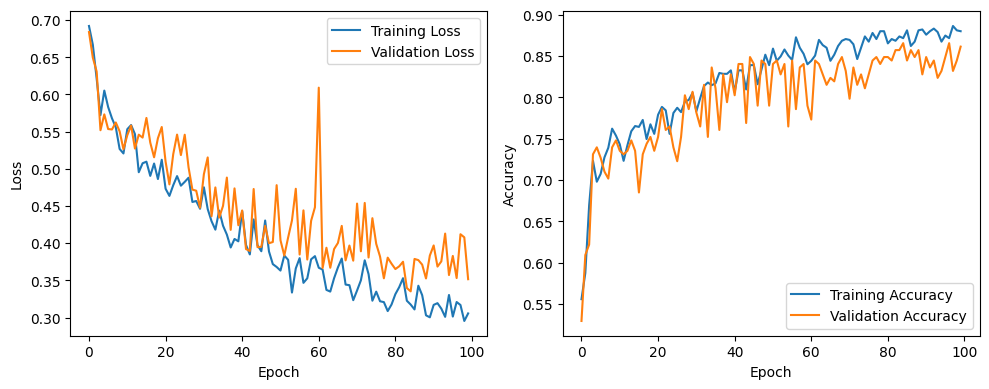

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex2.history['loss'], label='Training Loss')
plt.plot(history_ex2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex2.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_ex2.save('lstm_model_ex2.h5')

### Hyperparameters of Exp 2

Test Loss: 0.32892072200775146

Test Accuracy: 0.8825503587722778

In [ ]:
model_ex2v2 = Sequential()
model_ex2v2.add(LSTM(units=128, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex2v2.add(Dropout(0.7))
model_ex2v2.add(LSTM(units=64, return_sequences=True))
model_ex2v2.add(LSTM(units=32))
model_ex2v2.add(Dropout(0.7))
model_ex2v2.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)  # Using a different optimizer
model_ex2v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_ex2v2.summary()

batch_size = 32
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex2v2 = model_ex2v2.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 128)           91648     
                                                                 
 dropout_14 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 153,505
Trainable params: 153,505
Non-tr

In [ ]:
test_predictions = model_ex2v2.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex2v2.evaluate(test_X, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 11ms/step - loss: 0.4451 - accuracy: 0.7919
Test Loss: 0.44506028294563293
Test Accuracy: 0.791946291923523
Test F1-Score: 0.8472622478386167
Test Recall: 0.91875


In [ ]:
model_ex2v2.save('lstm_model_ex2v2.h5')

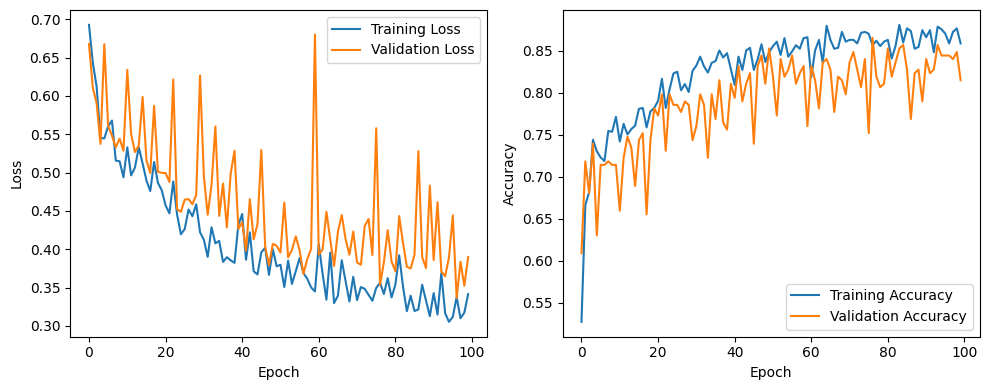

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex2v2.history['loss'], label='Training Loss')
plt.plot(history_ex2v2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex2v2.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex2v2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

10/10 [==============================] - 0s 24ms/step


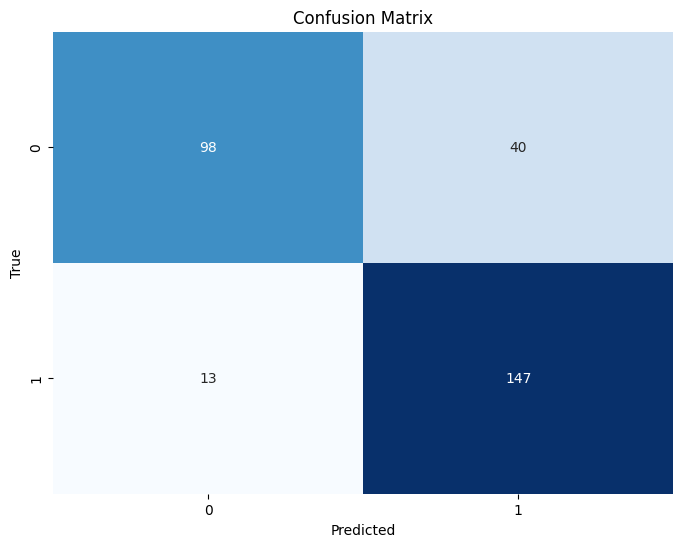

In [ ]:
# Predict probabilities on test data
predictions = model_ex2v2.predict(test_X)

# Convert probabilities to binary classes using a threshold (e.g., 0.5)
predicted_classes = (predictions > 0.7).astype(int)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_y, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameters of Exp 2 v3

In [ ]:
model_ex2v3 = Sequential()
model_ex2v3.add(LSTM(units=128, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex2v3.add(Dropout(0.7))
model_ex2v3.add(LSTM(units=64, return_sequences=True))
model_ex2v3.add(LSTM(units=32, return_sequences=True))
model_ex2v3.add(Dropout(0.7))
model_ex2v3.add(LSTM(units=16))
model_ex2v3.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)  # Using a different optimizer
model_ex2v3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_ex2v3.summary()

batch_size = 32
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex2v3 = model_ex2v3.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 10, 128)           91648     
                                                                 
 dropout_16 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_22 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_23 (LSTM)              (None, 10, 32)            12416     
                                                                 
 dropout_17 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_24 (LSTM)              (None, 16)                3136      
                                                                 
 dense_8 (Dense)             (None, 1)                

In [ ]:
test_predictions = model_ex2v3.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex2v3.evaluate(test_X, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 12ms/step - loss: 0.3702 - accuracy: 0.8624
Test Loss: 0.3701843023300171
Test Accuracy: 0.8624160885810852
Test F1-Score: 0.8507936507936507
Test Recall: 0.8375


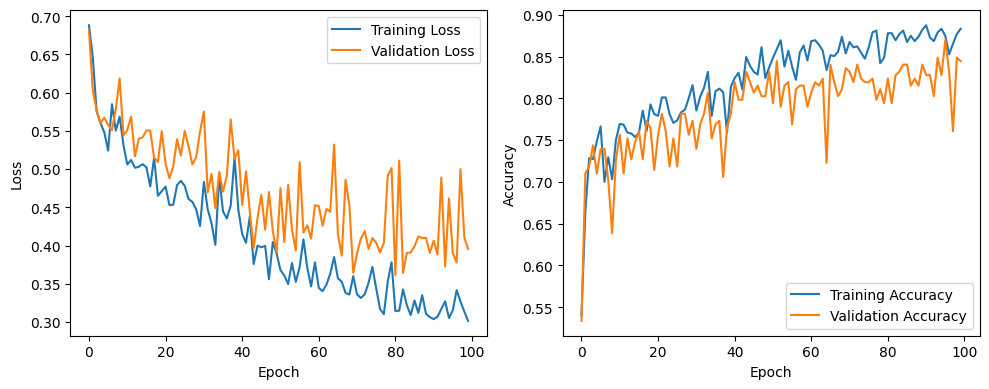

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex2v3.history['loss'], label='Training Loss')
plt.plot(history_ex2v3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex2v3.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex2v3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_ex2v3.save('lstm_model_ex2v3.h5')

### Hyperparameters of Exp 2 v4

In [ ]:
model_ex2v4 = Sequential()
model_ex2v4.add(LSTM(units=32, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex2v4.add(Dropout(0.7))
model_ex2v4.add(LSTM(units=64, return_sequences=True))
model_ex2v4.add(LSTM(units=128))
model_ex2v4.add(Dropout(0.7))
model_ex2v4.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_ex2v4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_ex2v4.summary()

batch_size = 32
epochs = 120
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex2v4 = model_ex2v4.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 10, 32)            10624     
                                                                 
 dropout_20 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_29 (LSTM)              (None, 10, 64)            24832     
                                                                 
 lstm_30 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 134,401
Trainable params: 134,401
Non-t

In [ ]:
test_predictions = model_ex2v4.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex2v4.evaluate(test_X, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 11ms/step - loss: 0.4415 - accuracy: 0.8456
Test Loss: 0.4415385127067566
Test Accuracy: 0.8456375598907471
Test F1-Score: 0.8187919463087248
Test Recall: 0.7625


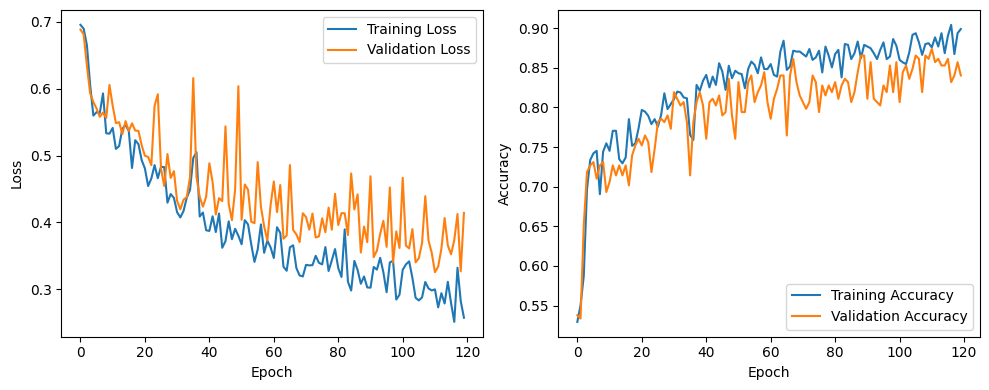

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex2v4.history['loss'], label='Training Loss')
plt.plot(history_ex2v4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex2v4.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex2v4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_ex2v4.save('lstm_model_ex2v4.h5')

## Experiment 3

In [ ]:
# Define the LSTM model
model_ex3 = Sequential()
model_ex3.add(LSTM(units=32, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex3.add(Dropout(0.7))
model_ex3.add(LSTM(units=64))
model_ex3.add(Dropout(0.5))
model_ex3.add(Dense(units=1, activation='sigmoid'))

custom_learning_rate = 0.001
optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model
model_ex3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model_ex3.summary()

# Train the model
batch_size = 32
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex3 = model_ex3.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 10, 32)            10624     
                                                                 
 dropout_22 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_32 (LSTM)              (None, 64)                24832     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 35,521
Trainable params: 35,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
30/30 [==============================

In [ ]:
test_predictions = model_ex3.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex3.evaluate(test_X, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 5ms/step - loss: 0.3982 - accuracy: 0.8490
Test Loss: 0.3982013165950775
Test Accuracy: 0.8489933013916016
Test F1-Score: 0.8463949843260189
Test Recall: 0.84375


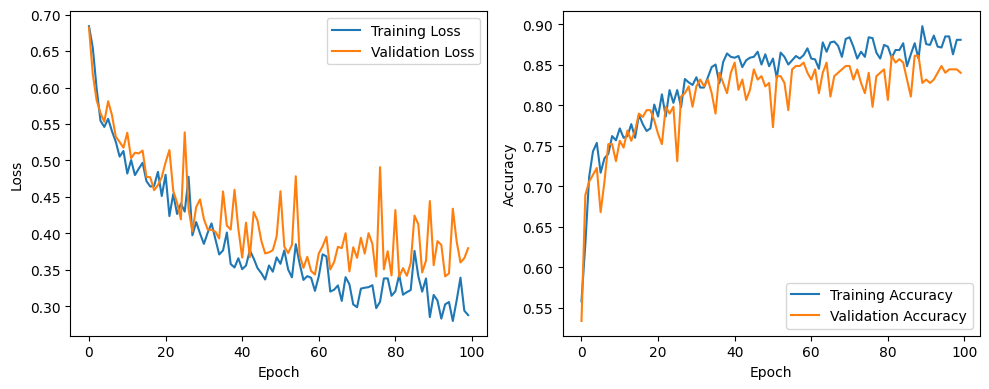

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex3.history['loss'], label='Training Loss')
plt.plot(history_ex3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex3.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_ex3.save('lstm_model_ex3.h5')

## Experiment 4

In [ ]:
model_ex4 = Sequential()
model_ex4.add(LSTM(units=128, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex4.add(Dropout(0.3))
model_ex4.add(LSTM(units=64, return_sequences=True))
model_ex4.add(Dropout(0.5))
model_ex4.add(LSTM(units=64))
model_ex4.add(Dropout(0.5))
model_ex4.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_ex4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
epochs = 100
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_ex4 = model_ex4.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/100
30/30 [==============================] - 10s 107ms/step - loss: 0.6960 - accuracy: 0.5253 - val_loss: 0.6829 - val_accuracy: 0.6218
Epoch 2/100
30/30 [==============================] - 2s 75ms/step - loss: 0.6662 - accuracy: 0.6074 - val_loss: 0.6321 - val_accuracy: 0.7185
Epoch 3/100
30/30 [==============================] - 3s 109ms/step - loss: 0.6235 - accuracy: 0.6811 - val_loss: 0.6524 - val_accuracy: 0.5924
Epoch 4/100
30/30 [==============================] - 3s 96ms/step - loss: 0.5841 - accuracy: 0.6853 - val_loss: 0.5565 - val_accuracy: 0.7269
Epoch 5/100
30/30 [==============================] - 3s 84ms/step - loss: 0.5525 - accuracy: 0.7474 - val_loss: 0.5954 - val_accuracy: 0.7059
Epoch 6/100
30/30 [==============================] - 2s 80ms/step - loss: 0.5285 - accuracy: 0.7695 - val_loss: 0.5547 - val_accuracy: 0.7311
Epoch 7/100
30/30 [==============================] - 2s 84ms/step - loss: 0.5283 - accuracy: 0.7526 - val_loss: 0.5679 - val_accuracy: 0.7101
Epo

In [ ]:
test_predictions = model_ex4.predict(test_X)
test_predictions_binary = (test_predictions > 0.7).astype(int)

test_f1 = f1_score(test_y, test_predictions_binary)
test_recall = recall_score(test_y, test_predictions_binary)

test_loss, test_accuracy = model_ex4.evaluate(test_X, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)
print("Test Recall:", test_recall)

10/10 [==============================] - 0s 12ms/step - loss: 0.3917 - accuracy: 0.8691
Test Loss: 0.3917073905467987
Test Accuracy: 0.8691275119781494
Test F1-Score: 0.8481012658227848
Test Recall: 0.8375


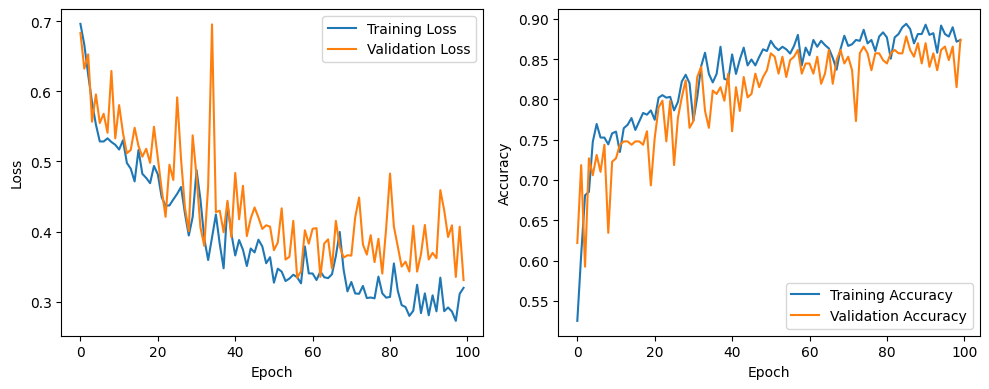

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex4.history['loss'], label='Training Loss')
plt.plot(history_ex4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex4.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_ex4.save('lstm_model_ex4.h5')

## Experiment 5

In [ ]:
from keras.layers import BatchNormalization

model_ex5 = Sequential()
model_ex5.add(LSTM(units=128, input_shape=(sequence_length, num_features), return_sequences=True))
model_ex5.add(Dropout(0.3))
model_ex5.add(LSTM(units=64, return_sequences=True))
model_ex5.add(Dropout(0.5))
model_ex5.add(LSTM(units=64))
model_ex5.add(Dropout(0.5))
model_ex5.add(Dense(units=1, activation='sigmoid'))

# Add BatchNormalization layers to improve convergence and generalization
model_ex5.add(BatchNormalization())

optimizer = Adam(learning_rate=0.001)
model_ex5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
epochs = 100

# Implement EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_ex5 = model_ex5.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
30/30 [==============================] - 11s 146ms/step - loss: 5.2788 - accuracy: 0.5000 - val_loss: 0.6885 - val_accuracy: 0.4832
Epoch 2/100
30/30 [==============================] - 2s 52ms/step - loss: 5.3407 - accuracy: 0.4926 - val_loss: 0.7296 - val_accuracy: 0.4664
Epoch 3/100
30/30 [==============================] - 1s 44ms/step - loss: 5.5098 - accuracy: 0.4705 - val_loss: 0.6941 - val_accuracy: 0.4664
Epoch 4/100
30/30 [==============================] - 1s 44ms/step - loss: 5.5009 - accuracy: 0.4726 - val_loss: 0.7195 - val_accuracy: 0.4664
Epoch 5/100
 9/30 [========>.....................] - ETA: 0s - loss: 5.6671 - accuracy: 0.4514

KeyboardInterrupt: ignored

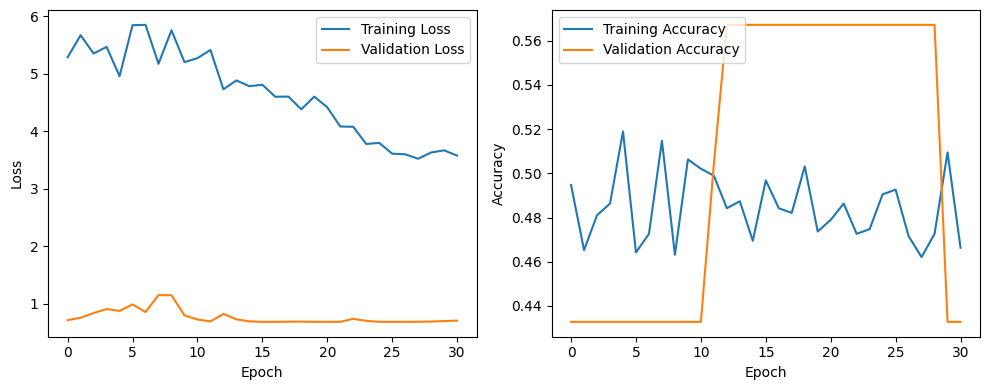

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex5.history['loss'], label='Training Loss')
plt.plot(history_ex5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex5.history['accuracy'], label='Training Accuracy')
plt.plot(history_ex5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Showing val accuracy and val loss

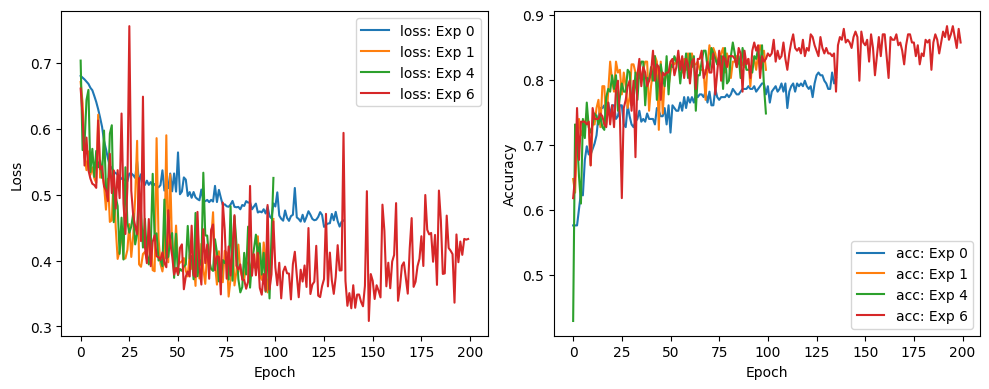

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ex0.history['val_loss'], label='loss: Exp 0')
plt.plot(history_ex1.history['val_loss'], label='loss: Exp 1')
# plt.plot(history_ex2.history['val_loss'], label='loss: Exp 2')
# plt.plot(history_ex3.history['val_loss'], label='loss: Exp 3')
plt.plot(history_ex4.history['val_loss'], label='loss: Exp 4')
plt.plot(history_ex6.history['val_loss'], label='loss: Exp 6')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ex0.history['val_accuracy'], label='acc: Exp 0')
plt.plot(history_ex1.history['val_accuracy'], label='acc: Exp 1')
# plt.plot(history_ex2.history['val_accuracy'], label='acc: Exp 2')
# plt.plot(history_ex3.history['val_accuracy'], label='acc: Exp 3')
plt.plot(history_ex4.history['val_accuracy'], label='acc: Exp 4')
plt.plot(history_ex6.history['val_accuracy'], label='acc: Exp 6')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()